# Objective: Build a short term trading (15 days) strategy using SARIMA model

## Import libraries

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import datetime
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

## Create Result df

In [5]:
result_df=pd.DataFrame(columns=['Ticker','Date_Split','p','d','q','P','D','Q','m','mape','Last_Day_True_Price',
                                'T_D1','T_D2','T_D3','T_D4','T_D5','T_D6','T_D7','T_D8',
                                'T_D9','T_D10','T_D11','T_D12','T_D13','T_D14','T_D15',
                                'P_D1','P_D2','P_D3','P_D4','P_D5','P_D6','P_D7','P_D8',
                                'P_D9','P_D10','P_D11','P_D12','P_D13','P_D14','P_D15'])
# p = AutoRegressive Order, d = Differencing Order, q = Moving Average Order
# P = Seasonal AutoRegressive Order, D = Seasonal Differencing Order, Q = Seasonal Moving Average Order
# m = Seasonal Periodicity
# mape = mean absolute percentage error
# T = True or Actual Value
# P = Predicted Value
# D = Days, D5 denotes 5th day price

## Defining time frames  

Selected time period is from 2020 jan to 2021 April. Final data is with time frame 2020 jan to 2024 October. Smaller time period is selected here to avoid server loading

In [8]:
dates = [datetime(2021,4,1),datetime(2021,3,1),datetime(2021,2,1),datetime(2021,1,1),datetime(2020,12,1),datetime(2020,11,1),
         datetime(2020,10,1),datetime(2020,9,1),datetime(2020,8,1),datetime(2020,7,1),datetime(2020,6,1),datetime(2020,5,1),
        datetime(2020,4,1),datetime(2020,3,1),datetime(2020,2,1),datetime(2020,1,1)]
# time frames for analysis
nifty_tickers=pd.read_excel("/Users/kuriankgeorge/Downloads/Nifty50.xlsx")
#  Nifty 50 tickers
tickers = nifty_tickers['SYMBOL \n'].apply(lambda x: x + ".NS").tolist()

## SARIMA modeling

In [10]:
 # Downloading stock price data from yf
for tic in tickers:
    ticker = tic
    start_date = "2018-06-01"
    end_date = "2024-11-14"
    data_all_initial = yf.download(ticker, start=start_date, end=end_date)
    data_all=data_all_initial[data_all_initial.columns[1]].to_frame()
    data_all.columns=['Close']
   
    # Splitting the data for different time frames, creating train and test df 
    for date in dates:
    
        train_df=data_all[:date].iloc[-500:]
        train_df=train_df[['Close']]
        test_df=data_all[(date+pd.Timedelta(days=1)):].iloc[:15]
        test_df=test_df[['Close']]
        last_test_date=test_df.index[-1].date()
        final_train_df=data_all[:last_test_date].iloc[-500:]
        final_train_df=final_train_df[['Close']]
        true_price_data=data_all[(last_test_date+pd.Timedelta(days=1)):].iloc[:15]
        true_price=true_price_data[['Close']]
        
        
        Last_Day_True_Price=final_train_df['Close'][-1]
        true_price['Per_Chng']=((true_price['Close'] - Last_Day_True_Price) / Last_Day_True_Price) * 100

        # Defining parameters for hyperparameter tuning
        arima_model = auto_arima(
        train_df,
        start_p=0, max_p=5,   # Range for AR term
        start_q=0, max_q=5,   # Range for MA term
        d=1,                  # Differencing order 
        start_P=0, max_P=5,   # Seasonal AR term
        start_Q=0, max_Q=5,   # Seasonal MA term
        D=1,                  # Seasonal differencing order
        m=5,                  # Seasonality period (Assuming 5 trading days in a week)
        seasonal=True,        # Enable seasonal component
        trace=False,           # Show the tuning progress
        error_action='ignore', 
        suppress_warnings=True, 
        stepwise=True,
        n_fits=20
        )
        
        # Getting the best parameters
        best_order = arima_model.order
        best_seasonal_order = arima_model.seasonal_order
        model = SARIMAX(train_df, order=best_order, seasonal_order=best_seasonal_order)
        sarimax_fit = model.fit(disp=False)
        
        # Getting the forecast for next 15 days
        forecast = sarimax_fit.get_forecast(steps=15)
        forecast_index = test_df.index
        forecast_values = forecast.predicted_mean

        # Calculate mape 
        forecast_values = np.array(forecast_values)
        forecast_values = pd.Series(forecast_values, index=test_df.index)
        mape = np.mean(np.abs((test_df['Close'] - forecast_values) / test_df['Close'])) * 100

        # Fiting the model with additional 15 days values
        best_order = arima_model.order
        best_seasonal_order = arima_model.seasonal_order
        final_model = SARIMAX(final_train_df, order=best_order, seasonal_order=best_seasonal_order)
        sarimax_final_fit = final_model.fit(disp=False)

        
        # Getting final forecast for 15 days
        forecast_final = sarimax_final_fit.get_forecast(steps=15)
        forecast_values_final = forecast.predicted_mean

        # Updating forecast values to df
        forecast_values_final=np.array(forecast_values_final)
        forecast_values_final=pd.DataFrame(forecast_values_final,columns=['Price'])
 
        # Getting Percentage change of price
        forecast_values_final['Per_Chng']=((forecast_values_final['Price'] - Last_Day_True_Price) / Last_Day_True_Price) * 100

        # Adding the results to df
        row={'Ticker':tic,'Date_Split':date,'p':arima_model.order[0],'d':arima_model.order[1],'q':arima_model.order[2],
         'P':arima_model.seasonal_order[0],'D':arima_model.seasonal_order[1],'Q':arima_model.seasonal_order[2],'m':arima_model.seasonal_order[3],
         'mape':mape,'Last_Day_True_Price':Last_Day_True_Price,
         'T_D1':true_price['Per_Chng'][0],'T_D2':true_price['Per_Chng'][1],'T_D3':true_price['Per_Chng'][2],
         'T_D4':true_price['Per_Chng'][3],'T_D5':true_price['Per_Chng'][4],'T_D6':true_price['Per_Chng'][5],
         'T_D7':true_price['Per_Chng'][6],'T_D8':true_price['Per_Chng'][7],'T_D9':true_price['Per_Chng'][8],
         'T_D10':true_price['Per_Chng'][9],'T_D11':true_price['Per_Chng'][10],'T_D12':true_price['Per_Chng'][11],
         'T_D13':true_price['Per_Chng'][12],'T_D14':true_price['Per_Chng'][13],'T_D15':true_price['Per_Chng'][14],
         'P_D1':forecast_values_final['Per_Chng'][0],'P_D2':forecast_values_final['Per_Chng'][1],'P_D3':forecast_values_final['Per_Chng'][2],
         'P_D4':forecast_values_final['Per_Chng'][3],'P_D5':forecast_values_final['Per_Chng'][4],'P_D6':forecast_values_final['Per_Chng'][5],
         'P_D7':forecast_values_final['Per_Chng'][6],'P_D8':forecast_values_final['Per_Chng'][7],'P_D9':forecast_values_final['Per_Chng'][8],
         'P_D10':forecast_values_final['Per_Chng'][9],'P_D11':forecast_values_final['Per_Chng'][10],'P_D12':forecast_values_final['Per_Chng'][11],
         'P_D13':forecast_values_final['Per_Chng'][12],'P_D14':forecast_values_final['Per_Chng'][13],'P_D15':forecast_values_final['Per_Chng'][14]}
    
        result_df = pd.concat([result_df, pd.DataFrame([row])], ignore_index=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
# Display all columns
pd.set_option('display.max_columns', None)

In [12]:
# Saving the results
result_df.to_csv("result_4.csv", index=False)

In [13]:
# Loading all the result df from 2020 jan to 2024 oct period
result_0_df=pd.read_csv("result.csv")
result_1_df=pd.read_csv("result_1.csv")
result_2_df=pd.read_csv("result_2.csv")
result_3_df=pd.read_csv("result_3.csv")
result_4_df=pd.read_csv("result_4.csv")
# Merging all df
merged_df = pd.concat([result_0_df, result_1_df, result_2_df,result_3_df,result_4_df], ignore_index=True)
# Shape of merged df
merged_df.shape

(2900, 41)

## Building the Strategy

In [15]:
# Setting the stop loss target, -5% if price<-5%, or else 15th day price
merged_df['Booked_Price']=merged_df['T_D15'].apply(lambda x:-5 if x<-5 else x)

In [16]:
# Creating df to update results
trade_result_df=pd.DataFrame(columns=['mape','P_D15','Total_Trade','Succ_Per','Avg_Return'])

In [17]:
# Creating range of mape and D15 percentage gain to build strategy
mape_list=[2,2.2,2.5,3]
P_D15_list=[4,4.5,5]

In [18]:
# Updating results
for mape in mape_list:
    for P_D15 in P_D15_list:
        condition_df=merged_df[(merged_df['mape']<mape)&(merged_df['P_D15']>P_D15)]
        total_trade=len(condition_df)
        success_trade=(condition_df['Booked_Price']>0).sum()
        per_success=round(((success_trade/total_trade)*100),2)
        avg_return=round((condition_df['Booked_Price'].mean()),2)

        row_1={'mape':f'<{mape}','P_D15':f'>{P_D15}','Total_Trade':total_trade,'Succ_Per':per_success,'Avg_Return':avg_return}

        trade_result_df = pd.concat([trade_result_df, pd.DataFrame([row_1])], ignore_index=True)

In [19]:
# Sorting values by success percentage
trade_result_df=trade_result_df.sort_values(by=['Succ_Per'],ascending=False).reset_index(drop=True)

In [20]:
trade_result_df

,mape,P_D15,Total_Trade,Succ_Per,Avg_Return
0,<3,>5,148,62.84,2.54
1,<2.5,>5,78,61.54,2.54
2,<2.2,>4,82,60.98,2.34
3,<2,>4,48,60.42,1.77
4,<3,>4.5,188,60.11,2.27
5,<3,>4,233,59.66,2.26
6,<2.2,>5,44,59.09,2.48
7,<2,>4.5,34,58.82,1.34
8,<2.2,>4.5,63,58.73,2.30
9,<2.5,>4,138,57.97,2.25


In [21]:
# Calculating the annual return for the best case, assuming 250 trading days in an year
annual_return=(250*2.54)/(15)

In [22]:
annual_return

42.333333333333336

## Evaluating Successful and Unsuccessful Cases

In [24]:
# Filter cases with mape < 3% and 15 day price > 5%
condition_df_new=merged_df[(merged_df['mape']<3)&(merged_df['P_D15']>4)]
# Filter required columns
condition_df_new=condition_df_new[['Ticker','Date_Split','p','d','q','P','D','Q','m','mape','T_D15','P_D15','Booked_Price']]
condition_df_new.head()

,Ticker,Date_Split,p,d,q,P,D,Q,m,mape,T_D15,P_D15,Booked_Price
7,COALINDIA.NS,2024-10-01,0,1,1,5,1,0,5,1.955200,-14.174227,4.547643,-5.000000
67,KOTAKBANK.NS,2024-07-01,0,1,1,5,1,0,5,2.014738,-0.952568,6.603278,-0.952568
77,RELIANCE.NS,2024-07-01,0,1,0,5,1,0,5,1.919108,-1.631496,8.227537,-1.631496
90,TECHM.NS,2024-09-01,0,1,0,5,1,0,5,2.557207,4.343266,4.572611,4.343266
92,TECHM.NS,2024-07-01,0,1,0,5,1,0,5,2.365357,0.669613,6.049475,0.669613


### Case 1: Successful Outcome

In [34]:
# Download TECHM price data from yf
ticker = "TECHM.NS"
start_date = "2018-06-01"
end_date = "2024-11-14"
data_all_initial = yf.download(ticker, start=start_date, end=end_date)
data_all=data_all_initial[data_all_initial.columns[1]].to_frame()
data_all.columns=['Close']

[*********************100%***********************]  1 of 1 completed


In [36]:
# Creating train and test df
date=datetime(2024, 9, 1)
train_df=data_all[:date].iloc[-500:]
train_df=train_df[['Close']]
test_df=data_all[(date+pd.Timedelta(days=1)):].iloc[:15]
test_df=test_df[['Close']]
last_test_date=test_df.index[-1].date()
final_train_df=data_all[:last_test_date].iloc[-500:]
final_train_df=final_train_df[['Close']]
true_price_data=data_all[(last_test_date+pd.Timedelta(days=1)):].iloc[:15]
true_price=true_price_data[['Close']]

In [38]:
# Storing last day price, 15 day per change to df
Last_Day_True_Price=final_train_df['Close'][-1]
true_price['Per_Chng']=((true_price['Close'] - Last_Day_True_Price) / Last_Day_True_Price) * 100

In [40]:
# Modeling
model = SARIMAX(final_train_df, order=(0,1,0), seasonal_order=(5,1,0,5))
sarimax_fit = model.fit(disp=False)

In [42]:
# Forecasting for 15 days
forecast = sarimax_fit.get_forecast(steps=15)
forecast_index = true_price.index
forecast_values = forecast.predicted_mean

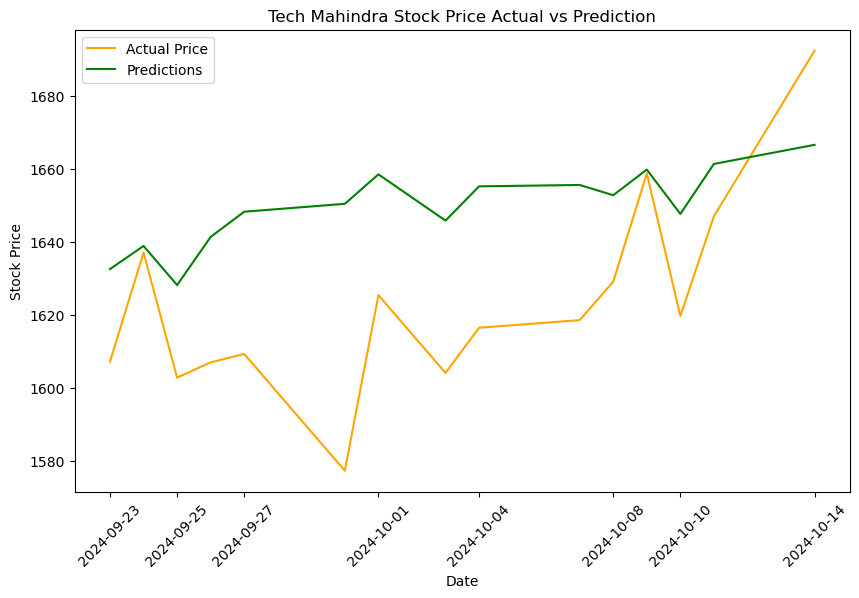

In [44]:
# Plotting Actual and Predicted Price
x_tic=true_price.index[::2]
plt.figure(figsize=(10, 6))
plt.plot(true_price.index, true_price['Close'], label='Actual Price', color='orange')
plt.plot(forecast_index, forecast_values, label='Predictions', color='green')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Tech Mahindra Stock Price Actual vs Prediction")
plt.xticks(ticks=x_tic,rotation=45)
plt.legend()
plt.show()

#### Checking the stationarity

In [46]:
from statsmodels.tsa.stattools import adfuller

In [48]:
result=adfuller(final_train_df['Close'])

In [50]:
if result[1]>0.05:
    print("Closing Price is not stationary")
else:
    print("Closing Price is stationary")

Closing Price is not stationary


In [52]:
final_train_df_copy=final_train_df['Close']

In [54]:
# Taking the first difference
final_train_df_copy=final_train_df_copy.diff()

In [56]:
final_train_df_copy.dropna(inplace=True)

In [58]:
result=adfuller(final_train_df_copy)
if result[1]>0.05:
    print("Closing Price is not stationary")
else:
    print("Closing Price is stationary")

Closing Price is stationary


First difference make the data stationary

#### Plotting ACF and PACF

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

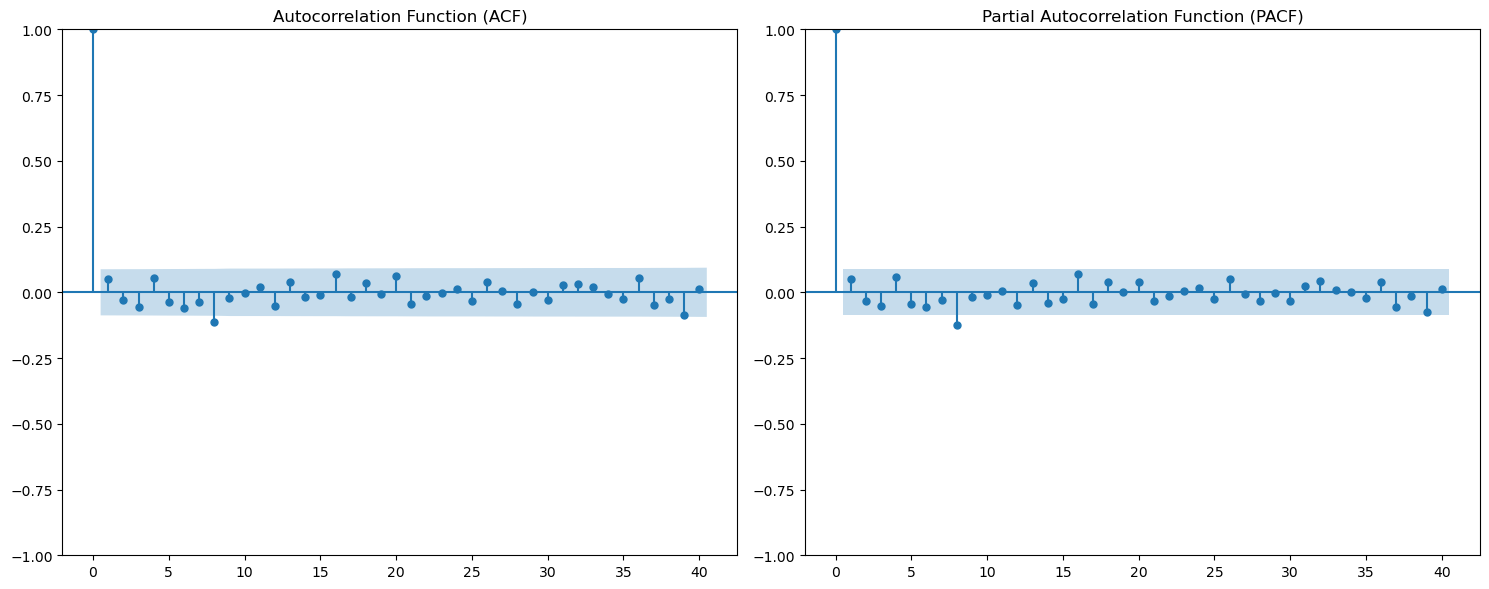

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(final_train_df_copy, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(final_train_df_copy, lags=40, method='ywm', ax=ax[1]) 
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

No significant spike observed

### Case 2: Unsuccessful Outcome

In [64]:
ticker = "COALINDIA.NS"
start_date = "2018-06-01"
end_date = "2024-11-14"
data_all_initial = yf.download(ticker, start=start_date, end=end_date)
data_all=data_all_initial[data_all_initial.columns[1]].to_frame()
data_all.columns=['Close']
date=datetime(2024, 10, 1)
train_df=data_all[:date].iloc[-500:]
train_df=train_df[['Close']]
test_df=data_all[(date+pd.Timedelta(days=1)):].iloc[:15]
test_df=test_df[['Close']]
last_test_date=test_df.index[-1].date()
final_train_df=data_all[:last_test_date].iloc[-500:]
final_train_df=final_train_df[['Close']]
true_price_data=data_all[(last_test_date+pd.Timedelta(days=1)):].iloc[:15]
true_price=true_price_data[['Close']]
Last_Day_True_Price=final_train_df['Close'][-1]
true_price['Per_Chng']=((true_price['Close'] - Last_Day_True_Price) / Last_Day_True_Price) * 100

[*********************100%***********************]  1 of 1 completed


In [66]:
model = SARIMAX(final_train_df, order=(0,1,1), seasonal_order=(5,1,0,5))
sarimax_fit = model.fit(disp=False)

In [68]:
forecast = sarimax_fit.get_forecast(steps=15)
forecast_index = true_price.index
forecast_values = forecast.predicted_mean

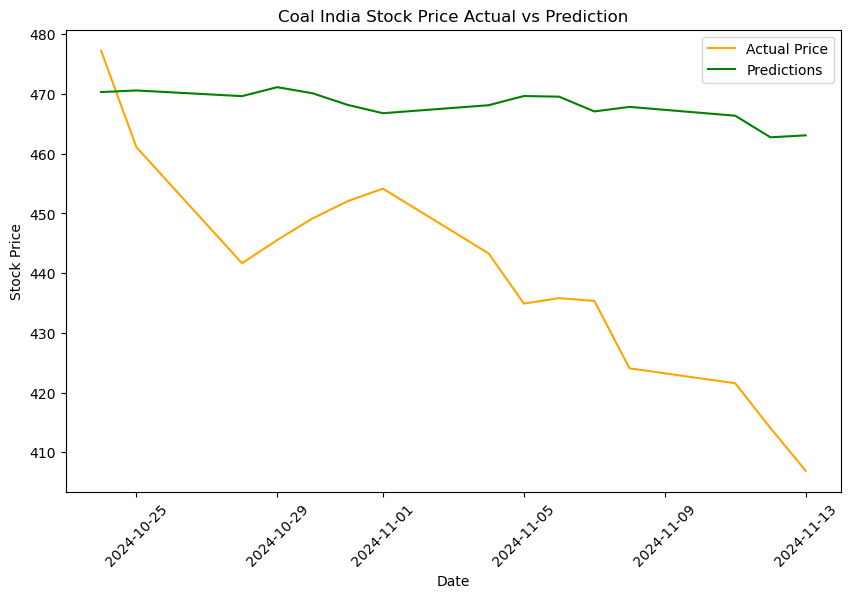

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(true_price.index, true_price['Close'], label='Actual Price', color='orange')
plt.plot(forecast_index, forecast_values, label='Predictions', color='green')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Coal India Stock Price Actual vs Prediction")
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### Checking the stationarity

In [72]:
result=adfuller(final_train_df['Close'])
if result[1]>0.05:
    print("Closing Price is not stationary")
else:
    print("Closing Price is stationary")

Closing Price is not stationary


In [74]:
final_train_df_copy=final_train_df['Close']
final_train_df_copy=final_train_df_copy.diff()
final_train_df_copy.dropna(inplace=True)
result=adfuller(final_train_df_copy)
if result[1]>0.05:
    print("Closing Price is not stationary")
else:
    print("Closing Price is stationary")

Closing Price is stationary


First difference make the data stationary

#### Plotting ACF and PACF

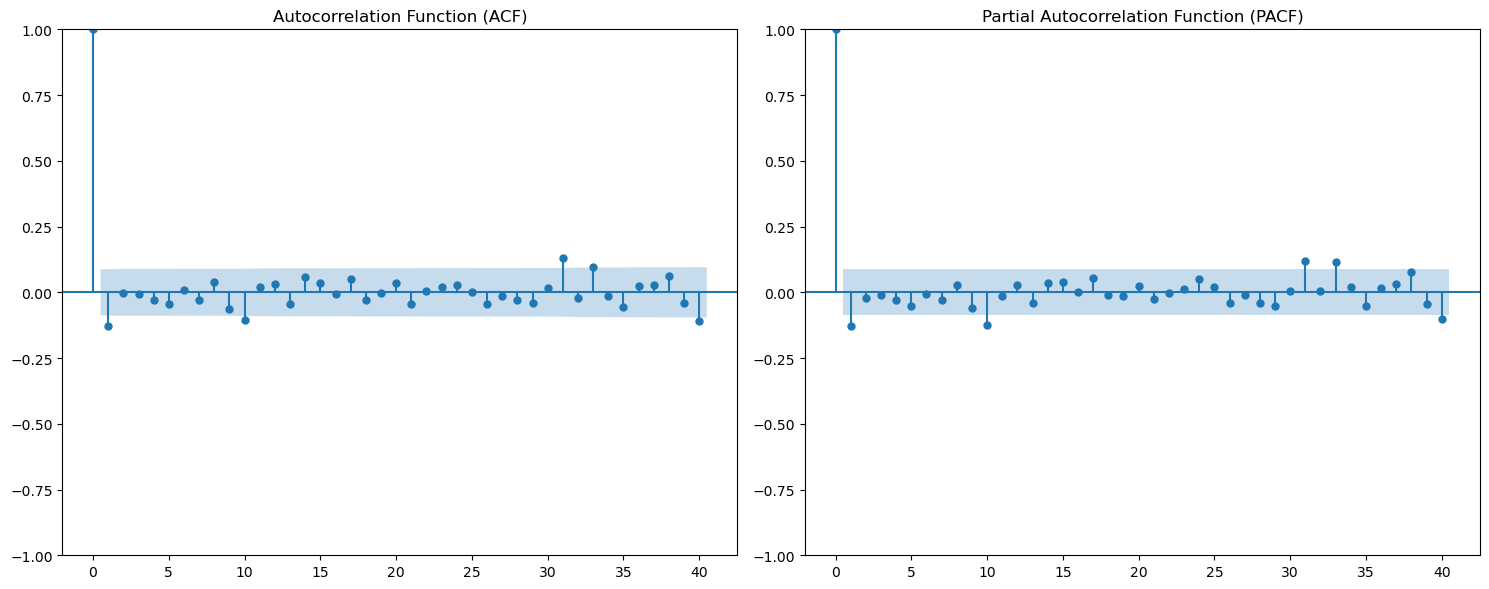

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(final_train_df_copy, lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(final_train_df_copy, lags=40, method='ywm', ax=ax[1])  
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()